# Travel times and accessibility in Vienna

In this notebook we show the results of the data collection of:

* the location of the nearest POI of some type, starting from the centroid of a given grid cell in Vienna;
* the time required to reach the latter.

The notebook calls wrap functions from the scripts "src/data/download_pois_networks.py" and "src/data/travel_times.py". 

## Imports

In [129]:
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import geopandas as gpd
import pickle
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('../src/data')
from download_pois_networks import download_POIs
from download_pois_networks import download_street_network, networks_to_gdf, analyze_street_network

In [130]:
EQUAL_AREA_PROJ = '+proj=cea'
LON_LAT_PROJ = 'EPSG:4326'
MERCATOR_PROJ = 'epsg:3395'

## Utils, the haversine distance function

In [131]:
def haversine(coord1, coord2):
    """
    Calculate the Haversine distance between two points on the Earth.

    Args:
        coord1 (tuple): (longitude, latitude) of the first point in degrees.
        coord2 (tuple): (longitude, latitude) of the second point in degrees.

    Returns:
        float: Distance in kilometers.
    """
    # Radius of the Earth in km
    R = 6371.0  
    
    # Convert degrees to radians
    lon1, lat1 = map(math.radians, coord1)
    lon2, lat2 = map(math.radians, coord2)
    
    # Differences in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # Compute the distance
    distance = R * c
    
    return distance

## Read data

In [132]:
raw_data_path = '../data/raw/'
os.listdir(raw_data_path)

['ViennaAustria_r8_travel_times_old.pkl',
 'ViennaAustria_r8_nearest_loc_old.pkl',
 'ViennaAustria.pkl',
 'ViennaAustria_r8_travel_times.pkl',
 'ViennaAustria_networks.pkl',
 'ViennaAustria_r8_nearest_loc.pkl',
 'ViennaAustria_r8_hex_grid.pkl']

In [133]:
with open(f'{raw_data_path}ViennaAustria_r8_travel_times.pkl','rb') as f:
    gdf_travel_time = pickle.load(f)

with open('../data/raw/ViennaAustria_r8_nearest_loc.pkl','rb') as f:
    gdf_nearest_loc = pickle.load(f)

display(gdf_travel_time.head(5))
display(gdf_nearest_loc.head(5))

,geometry,hex_id,timeto_shop_supermarket
0,"POLYGON ((16.50612 48.17424, 16.50206 48.17170...",885250cebbfffff,50.181833
1,"POLYGON ((16.52967 48.16208, 16.52561 48.15954...",885250ce89fffff,77.992167
2,"POLYGON ((16.49395 48.16661, 16.48989 48.16407...",885250ceb7fffff,30.450333
3,"POLYGON ((16.27151 48.17955, 16.26746 48.17702...",8852504663fffff,7.548833
4,"POLYGON ((16.30338 48.18162, 16.29932 48.17908...",88525054a7fffff,4.790833


,geometry,hex_id,nearest_shop_supermarket
0,"POLYGON ((16.50612 48.17424, 16.50206 48.17170...",885250cebbfffff,"(16.473657, 48.169685)"
1,"POLYGON ((16.52967 48.16208, 16.52561 48.15954...",885250ce89fffff,"(16.473657, 48.169685)"
2,"POLYGON ((16.49395 48.16661, 16.48989 48.16407...",885250ceb7fffff,"(16.473657, 48.169685)"
3,"POLYGON ((16.27151 48.17955, 16.26746 48.17702...",8852504663fffff,"(16.270322, 48.177753)"
4,"POLYGON ((16.30338 48.18162, 16.29932 48.17908...",88525054a7fffff,"(16.297919, 48.185629)"


In [134]:
gdf_travel_time.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 924 non-null    geometry
 1   hex_id                   924 non-null    object  
 2   timeto_shop_supermarket  913 non-null    float64 
dtypes: float64(1), geometry(1), object(1)
memory usage: 21.8+ KB


In [135]:
gdf_nearest_loc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   geometry                  924 non-null    geometry
 1   hex_id                    924 non-null    object  
 2   nearest_shop_supermarket  913 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 21.8+ KB


## Visualization, travel times

<Axes: xlabel='timeto_shop_supermarket', ylabel='Count'>

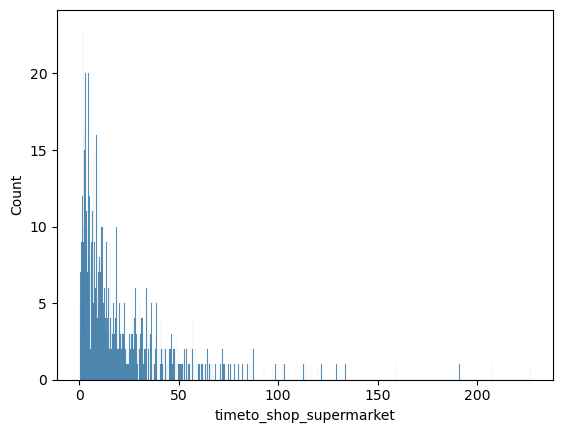

In [136]:
sns.histplot(gdf_travel_time['timeto_shop_supermarket'],bins=gdf_travel_time.shape[0])

In [137]:
print(np.where(np.isnan(gdf_travel_time['timeto_shop_supermarket'])))

(array([ 23,  54,  96, 111, 142, 253, 268, 506, 650, 709, 843]),)


Text(0.5, 1.0, 'Travel time to closest supermarket')

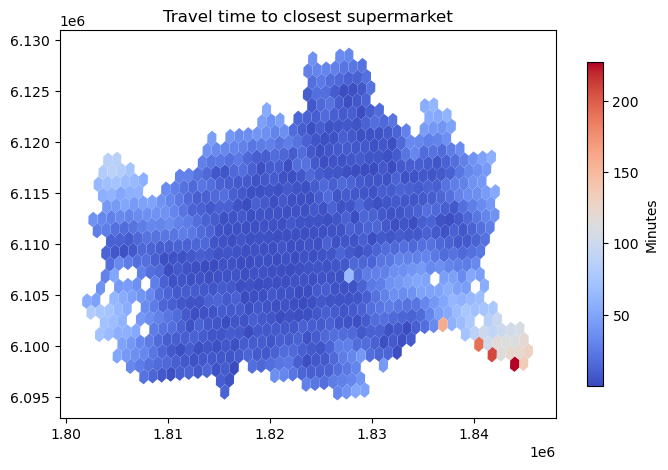

In [138]:
fig, ax = plt.subplots(figsize=(8,6))

gdf_plot = gdf_travel_time.to_crs(MERCATOR_PROJ)
gdf_plot.plot(column='timeto_shop_supermarket',cmap='coolwarm',
              legend=True, legend_kwds={'shrink': 0.7, 'label': 'Minutes'},
              ax=ax)

ax.set_title('Travel time to closest supermarket')
#ax.set_axis_off()

<Axes: >

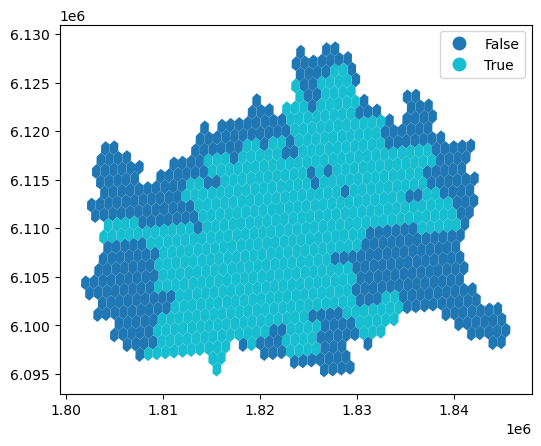

In [140]:
gdf_plot = gdf_travel_time.to_crs(MERCATOR_PROJ)
gdf_plot['<15_min'] = gdf_travel_time['timeto_shop_supermarket']<15
gdf_plot.plot(column='<15_min',legend=True)

## Travel times and distance

In [108]:
# Haversine distance between two centroids
cen = gdf_nearest_loc.geometry.iloc[0].centroid
cen = (cen.x,cen.y)
ame = gdf_nearest_loc.nearest_shop_supermarket.iloc[0]
print(cen)
print(ame)
print(haversine(cen,ame))

(16.502193097460083, 48.17626363340371)
(16.473657, 48.169685)
2.238940971073067
